In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("../derrom/")

import derrom

In [2]:
import torch

In [3]:
trajectories = derrom.utils.load_trajectories(filename='../../trajectories_n_kmax=200.npz')

trajectories = trajectories[::10]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)


test_trajectory = derrom.utils.load_trajectories(filename='../../example_trajectory.npz')[0]
print('example trajectory loaded with shape: ', test_trajectory.shape)

100 loaded with n_kmax = 200
example trajectory loaded with shape:  (400, 200)


In [4]:
# data_matrix = np.concatenate(trajectories)
data_matrix = np.concatenate([t[[0,5,10,20,50,100,200,399]] for t in trajectories])
# data_matrix = np.concatenate([t[[0,50,100,399]] for t in trajectories])

print(data_matrix.shape)

(800, 200)


In [5]:
# print(data_matrix.dtype)

data_tensor = torch.from_numpy(data_matrix.astype(np.float32))
print(data_tensor.shape)
print(data_tensor.dtype)

torch.Size([800, 200])
torch.float32


In [6]:
class CAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1,16,3,padding='same',padding_mode='replicate'),
            torch.nn.Tanh(),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(16,32,3,padding='same',padding_mode='replicate'),
            torch.nn.Tanh(),
            torch.nn.MaxPool1d(2),
            torch.nn.Conv1d(32,64,3,padding='same',padding_mode='replicate'),
            torch.nn.Tanh(),
            torch.nn.MaxPool1d(2),
            torch.nn.Flatten(0,-1),
            torch.nn.Linear(1600,10)
        )

         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 1600),
            torch.nn.Unflatten(0,(1,64,25)),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose1d(64,32,3, padding=1),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose1d(32,16,3, padding=1),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose1d(16,1,3, padding=1)
        )
 
    
    def forward(self, x):
        x = torch.reshape(x,(1,1,-1))
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = torch.reshape(decoded,(-1,))
        return decoded
    
#### Model Initialization
model = CAE()
print(model)

CAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
    (4): Tanh()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
    (7): Tanh()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=0, end_dim=-1)
    (10): Linear(in_features=1600, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1600, bias=True)
    (1): Unflatten(dim=0, unflattened_size=(1, 64, 25))
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Tanh()
    (4): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1

In [7]:
input = data_tensor[0]
# input = torch.rand(100)

input = torch.reshape(input,(1,-1))

print(input.shape)

latent = model.encoder(input)
print(latent.shape)

recon = model.decoder(latent)
print(recon.shape)

test = model(input)
print(test.shape)

torch.Size([1, 200])
torch.Size([10])
torch.Size([1, 1, 200])
torch.Size([200])


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:


def PI_loss(output, target):
    loss = torch.mean((output-target)**2) + 0.01*torch.mean( torch.tanh(-20.*(output+0.2)) + 1 )
#     loss = torch.mean((output-target)**2) + torch.mean( torch.nn.functional.relu(-100.*output) )
    return loss

criterion = PI_loss
criterion = torch.nn.MSELoss()

In [10]:
def train(net, states, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in states:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(states)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.6f}'.format(
            epoch+1, NUM_EPOCHS, loss))
    return train_loss


In [11]:
# get the computation device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load the neural network onto the device
model.to(device)

cpu


CAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
    (1): Tanh()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
    (4): Tanh()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same, padding_mode=replicate)
    (7): Tanh()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=0, end_dim=-1)
    (10): Linear(in_features=1600, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1600, bias=True)
    (1): Unflatten(dim=0, unflattened_size=(1, 64, 25))
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Tanh()
    (4): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1

In [12]:
# train the network
train_loss = train(model, data_tensor, 100)

Epoch 1 of 100, Train Loss: 0.012929
Epoch 2 of 100, Train Loss: 0.003871
Epoch 3 of 100, Train Loss: 0.002832
Epoch 4 of 100, Train Loss: 0.002337
Epoch 5 of 100, Train Loss: 0.001864
Epoch 6 of 100, Train Loss: 0.001620
Epoch 7 of 100, Train Loss: 0.001561
Epoch 8 of 100, Train Loss: 0.001362
Epoch 9 of 100, Train Loss: 0.001079
Epoch 10 of 100, Train Loss: 0.001342
Epoch 11 of 100, Train Loss: 0.000950
Epoch 12 of 100, Train Loss: 0.001254
Epoch 13 of 100, Train Loss: 0.000836
Epoch 14 of 100, Train Loss: 0.000788
Epoch 15 of 100, Train Loss: 0.000806
Epoch 16 of 100, Train Loss: 0.000824
Epoch 17 of 100, Train Loss: 0.000822
Epoch 18 of 100, Train Loss: 0.000769
Epoch 19 of 100, Train Loss: 0.000785
Epoch 20 of 100, Train Loss: 0.000763
Epoch 21 of 100, Train Loss: 0.000679
Epoch 22 of 100, Train Loss: 0.000790
Epoch 23 of 100, Train Loss: 0.000749
Epoch 24 of 100, Train Loss: 0.000671
Epoch 25 of 100, Train Loss: 0.000795
Epoch 26 of 100, Train Loss: 0.000700
Epoch 27 of 100, Trai

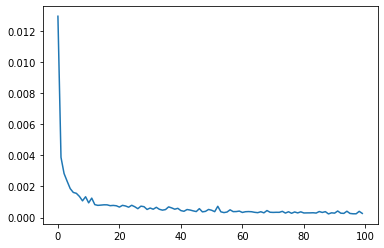

In [13]:
plt.plot(train_loss)
plt.show()

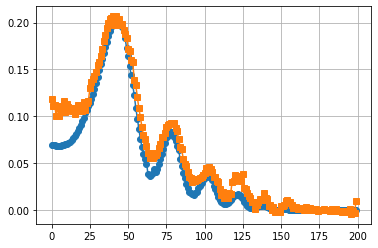

In [14]:
test = data_tensor[324]

recon = model(test).detach().numpy()

plt.grid()
plt.plot(test, marker='o')
plt.plot(recon, marker = 's')

plt.show()

In [15]:
torch.save(model, '../../torch_model_test')

torch.Size([10])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
(200,)


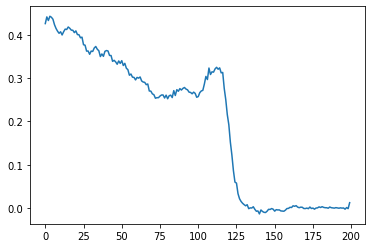

In [16]:
latent_vec = torch.zeros((10), dtype=torch.float32)

latent_vec[0] = 1
print(latent_vec.shape)
print(latent_vec)

data = model.decoder(latent_vec).detach().numpy().reshape(-1)

print(data.shape)

plt.plot(data)
plt.show()


In [19]:
class AEDR(derrom.dim_reducers.base_dim_reducer):
    def __init__(self, AEmodel=None):
        self.AEmodel = AEmodel
    
    def train(self, data_matrix, rdim):
        pass
    
    def reduce(self, data_matrix, rdim):
        data_tensor = torch.from_numpy(data_matrix.astype(np.float32))
        
        out = np.zeros((data_tensor.shape[0],10))
        for k in range(data_tensor.shape[0]):
            out[k] = self.AEmodel.encoder(data_tensor[k].reshape(1,-1)).detach().numpy()
        return out
    
    def reconstruct(self, reduced_data_matrix):
        data_tensor = torch.from_numpy(reduced_data_matrix.astype(np.float32))
        
        out = np.zeros((data_tensor.shape[0],200))
        for k in range(data_tensor.shape[0]):
            out[k] = self.AEmodel.decoder(data_tensor[k]).detach().numpy().reshape(-1)
        return out

        

In [20]:
dim_reducer = AEDR(model)

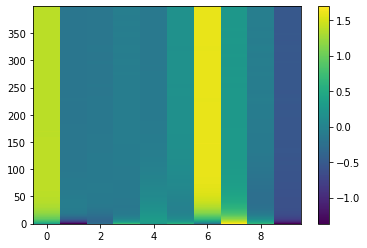

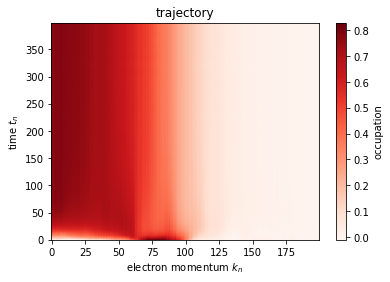

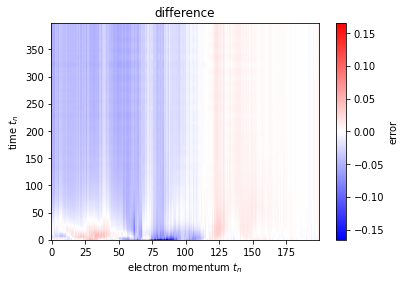

In [22]:
test = trajectories[10]

red = dim_reducer.reduce(test, rdim=10)

recon = dim_reducer.reconstruct(red)

plt.imshow(red, aspect='auto', interpolation='none', origin='lower')
plt.colorbar()
plt.show()

derrom.utils.plot_trajectory(recon)

derrom.utils.plot_difference(truth=test, test=recon)